In [2]:
import os
import librosa
import numpy as np
from scipy.io.wavfile import write
from icecream import ic


def normalize_audio(input_dir, output_dir, subfolder_name):
    
    #Create the subdirectory for the normalized audio
    output_subdir = os.path.join(output_dir, subfolder_name)
    os.makedirs(output_subdir, exist_ok=True)
    
    for filename in os.listdir(input_dir):
        if filename.endswith('.wav'):
            file_path = os.path.join(input_dir, filename)
            try:
                # Perform the normalization
                audio, sr = librosa.load(file_path, sr=None)
                audio_normalized = librosa.util.normalize(audio)
                output_path = os.path.join(output_subdir, filename)
                write(output_path, sr, (audio_normalized * 32767).astype(np.int16))
                

            except Exception as e:
                print(f"Error processing file {file_path}: {e}")
    
    #return the subdirectory path for future usage.            
    return output_subdir




# Update the paths to be relative to the Jupyter Notebook's directory
notebook_dir = os.getcwd()


#Folder names can be changed here.
CAR_SAMPLES_FOLDERNAME = "car_samples"
TRAM_SAMPLES_FOLDERNAME = "tram_samples"

OUTPUT_FOLDERNAME = "normalized_audio"

CAR_OUTPUT_NAME = "car_normalized"
TRAM_OUTPUT_NAME = "tram_normalized"



car_samples_dir = os.path.join(notebook_dir, CAR_SAMPLES_FOLDERNAME)
tram_samples_dir = os.path.join(notebook_dir, TRAM_SAMPLES_FOLDERNAME)
normalized_dir = os.path.join(notebook_dir, OUTPUT_FOLDERNAME)

car_normalized_dir = normalize_audio(car_samples_dir, normalized_dir, CAR_OUTPUT_NAME)
tram_normalized_dir = normalize_audio(tram_samples_dir, normalized_dir, TRAM_OUTPUT_NAME)

print ("car_samples_dir: ", car_samples_dir)
print ("tram_samples_dir: ", tram_samples_dir)
print ("normalized_dir: ", normalized_dir)
print ("car_normalized_dir: ", car_normalized_dir)
print ("tram_normalized_dir: ", tram_normalized_dir)


car_samples_dir:  c:\Users\Jose\Desktop\Tampere\TUNI\Audio\Project Work\car_samples
tram_samples_dir:  c:\Users\Jose\Desktop\Tampere\TUNI\Audio\Project Work\tram_samples
normalized_dir:  c:\Users\Jose\Desktop\Tampere\TUNI\Audio\Project Work\normalized_audio
car_normalized_dir:  c:\Users\Jose\Desktop\Tampere\TUNI\Audio\Project Work\normalized_audio\car_normalized
tram_normalized_dir:  c:\Users\Jose\Desktop\Tampere\TUNI\Audio\Project Work\normalized_audio\tram_normalized


## 1. Data

- The data consists of normalized audio samples from two classes: car_samples and tram_samples.
- Samples are stored in a structured directories.
- Note:
    - Only 30 samples per class are available, which is small for training a robust model.
    - As the recordings are homogeneous the model may struggle with generalization.


In [11]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

LABEL_MAP = {
    0: CAR_OUTPUT_NAME,
    1: TRAM_OUTPUT_NAME
}

#extract from the normalized audio dir
#the noise factor is used later in the tests
def advanced_extract_features(audio_dir, noise_factor = 0.0, debug = False):
    features = []
    labels = []
    
    
    #iterate over both normalized subdirectories
    for label, subdir in LABEL_MAP.items():
        
        #folder_path is the normalized_subdir in every iteration
        folder_path = os.path.join(audio_dir, subdir)
        
        
        #iterate over every file in the normalized_subdir
        for filename in os.listdir(folder_path):
            #sanity check for the file extension
            if filename.endswith('.wav'):
                
                #file_path is the full path of the file
                file_path = os.path.join(folder_path, filename)
                
                
                #perform the feature extraction
                try:
                    audio, sr = librosa.load(file_path, sr = None)
                    
                    #Apply noise if given
                    if noise_factor > 0:
                        audio = audio + noise_factor * np.random.randn(len(audio))
                    
                    #Limiting the length of the audio to 5 seconds
                    n_fft = min(1024, len(audio))
    
                    # Debugging information
                    if (debug): 
                        print(f"Length of audio: {len(audio)}, n_fft: {n_fft}")
    
                    
                    
                    # Time-Frequency Representation
                    stft = np.abs(librosa.stft(audio, n_fft=n_fft, hop_length=n_fft//2))
                    chroma = librosa.feature.chroma_stft(S=stft, sr=sr, n_fft=len (stft))
                    
                    # Extract Features
                    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr, n_fft=n_fft))
                    spectral_contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sr, n_fft= len(stft)))
                    tonnetz = np.mean(librosa.feature.tonnetz(y=audio, sr=sr), axis=1)
                    rms = np.mean(librosa.feature.rms(y=audio, frame_length=n_fft, hop_length=n_fft//2))
                    zcr = np.mean(librosa.feature.zero_crossing_rate(y=audio, frame_length=n_fft, hop_length=n_fft//2))
                    mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13), axis=1)
                    
                    # Aggregate features
                    feature_vector = (
                    [
                        spectral_centroid, 
                        spectral_contrast, 
                        rms, 
                        zcr
                    ] 
                    + list(mfccs) 
                    + list(tonnetz) 
                    + list(np.mean(chroma, axis=1))
                                    )
                    
                    features.append(feature_vector)
                    labels.append(label)
                    
                
                except Exception as e:
                    print(f"Error extracting features from {file_path}: {e}")
    
    # Create DataFrame
    feature_names = (
        ['Spectral_Centroid', 'Spectral_Contrast', 'RMS', 'ZCR'] +
        [f'MFCC_{i}' for i in range(13)] +
        [f'Tonnetz_{i}' for i in range(6)] +
        [f'Chroma_{i}' for i in range(12)]
    )
    
    return pd.DataFrame(features, columns=feature_names), np.array(labels)

features_df, labels = advanced_extract_features(normalized_dir, debug= True)



Length of audio: 153935, n_fft: 1024
Length of audio: 159007, n_fft: 1024
Length of audio: 141358, n_fft: 1024
Length of audio: 159950, n_fft: 1024
Length of audio: 170274, n_fft: 1024
Length of audio: 190241, n_fft: 1024
Length of audio: 118532, n_fft: 1024
Length of audio: 123233, n_fft: 1024
Length of audio: 77927, n_fft: 1024
Length of audio: 149069, n_fft: 1024
Length of audio: 170716, n_fft: 1024
Length of audio: 172056, n_fft: 1024
Length of audio: 138766, n_fft: 1024
Length of audio: 153263, n_fft: 1024
Length of audio: 181231, n_fft: 1024
Length of audio: 118184, n_fft: 1024
Length of audio: 168834, n_fft: 1024
Length of audio: 118624, n_fft: 1024
Length of audio: 140673, n_fft: 1024
Length of audio: 70975, n_fft: 1024
Length of audio: 100260, n_fft: 1024
Length of audio: 83778, n_fft: 1024
Length of audio: 101354, n_fft: 1024
Length of audio: 153552, n_fft: 1024
Length of audio: 99680, n_fft: 1024
Length of audio: 221562, n_fft: 1024
Length of audio: 189591, n_fft: 1024
Lengt

In [4]:
features_df.head(32)

,Spectral_Centroid,Spectral_Contrast,RMS,ZCR,MFCC_0,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,...,Chroma_2,Chroma_3,Chroma_4,Chroma_5,Chroma_6,Chroma_7,Chroma_8,Chroma_9,Chroma_10,Chroma_11
0,2050.232900,14.648353,0.137128,0.045827,-151.099640,206.130920,-31.726160,-13.577496,-8.310178,-1.014483,...,0.685537,0.667408,0.675903,0.710831,0.734846,0.720558,0.715212,0.739940,0.792571,0.817141
1,2259.107324,14.312314,0.130864,0.049849,-153.421417,186.106293,-36.599583,-5.559267,-12.891334,-7.956305,...,0.676561,0.633089,0.656296,0.659970,0.683096,0.735676,0.799043,0.818359,0.817124,0.776772
2,1675.836791,14.638307,0.140061,0.043825,-176.407654,217.090622,-42.363041,-9.337881,-1.760331,-20.944395,...,0.629981,0.610468,0.627621,0.660378,0.698118,0.747812,0.778833,0.780656,0.797336,0.758221
3,1630.217965,14.136743,0.104533,0.042251,-214.173676,217.148117,-39.975407,-18.308235,0.741996,-21.516821,...,0.672511,0.638667,0.645262,0.597178,0.540410,0.555057,0.629649,0.736754,0.821847,0.864574
4,2255.214285,14.547952,0.107903,0.049418,-176.270462,181.426453,-37.028378,-9.953622,-18.049059,-10.776788,...,0.574943,0.559699,0.592523,0.623810,0.702808,0.761191,0.778857,0.798282,0.816778,0.786745
5,2040.267579,14.323694,0.100688,0.046570,-193.648483,186.713165,-29.896465,-11.783064,-17.254009,-14.466020,...,0.579111,0.583586,0.613810,0.659277,0.725826,0.768335,0.792261,0.799069,0.760831,0.734083
6,1736.455633,14.497610,0.145539,0.043486,-164.087036,212.108353,-43.081894,-8.830587,-7.238092,-21.505329,...,0.599764,0.599455,0.612198,0.630981,0.698082,0.763583,0.798370,0.811057,0.803864,0.762795
7,1914.479553,14.426676,0.117903,0.033937,-207.008301,180.793152,-9.339801,-8.822227,11.060160,6.075059,...,0.731217,0.728735,0.747902,0.778799,0.803761,0.807520,0.792733,0.769195,0.802968,0.813562
8,2581.698505,14.905981,0.179249,0.056207,-89.755676,175.659653,-45.287617,-16.659399,-8.739002,-3.197886,...,0.632632,0.632820,0.656346,0.718509,0.768434,0.784613,0.767808,0.770443,0.826562,0.824821
9,2338.280760,14.213588,0.083205,0.051664,-247.167221,185.975494,-23.511713,-6.434653,-4.032462,-21.992716,...,0.620991,0.609818,0.629973,0.668783,0.726975,0.772040,0.818686,0.844400,0.825371,0.734093


## 2. Feature Extraction
### Features Extracted:

- Basic features: Spectral Centroid, Spectral Contrast, RMS, ZCR.
- Advanced features: MFCCs (13 coefficients), Tonnetz (6 harmonic features), Chroma (12 pitch classes).
- STFT time-frequency representation was used to capture the spectral content.
### Strengths:

- Comprehensive feature set incorporating time-domain and frequency-domain information.
- MFCCs are particularly effective for characterizing audio signals.
### Weaknesses:

- The number of features is large relative to the dataset size, which increases the risk of overfitting.


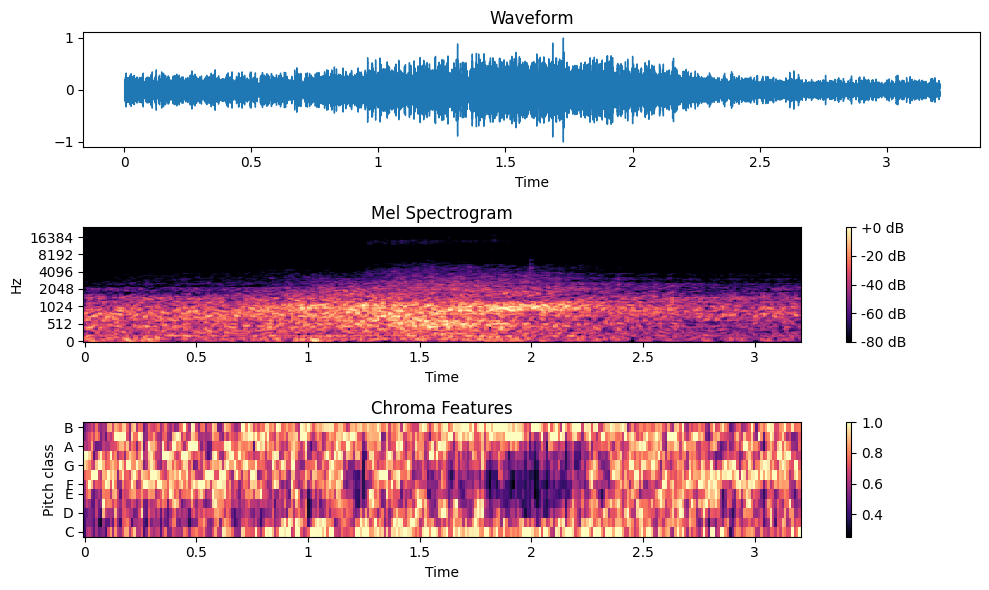

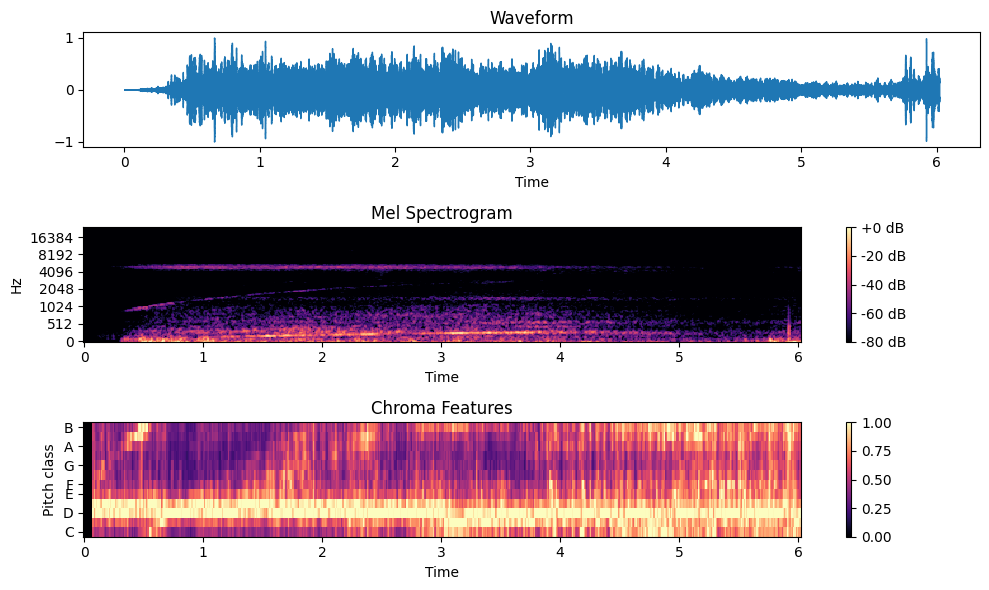

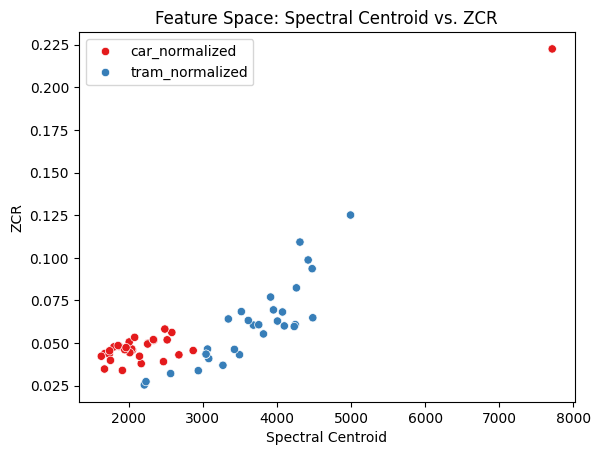

In [12]:
import matplotlib.pyplot as plt
import librosa.display

def visualize_audio_features(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    stft = librosa.stft(audio)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
    chroma = librosa.feature.chroma_stft(S=np.abs(stft), sr=sr)

    # Plot Waveform
    plt.figure(figsize=(10, 6))
    plt.subplot(3, 1, 1)
    librosa.display.waveshow(audio, sr=sr)
    plt.title("Waveform")
    
    # Plot Spectrogram
    plt.subplot(3, 1, 2)
    librosa.display.specshow(librosa.amplitude_to_db(mel_spectrogram, ref=np.max), 
                             sr=sr, x_axis='time', y_axis='mel')
    
    plt.title("Mel Spectrogram")
    plt.colorbar(format="%+2.0f dB")
    
    # Plot Chroma
    plt.subplot(3, 1, 3)
    librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', sr=sr)
    plt.title("Chroma Features")
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()



def visualize_first_available_audio(directory):
    files = [f for f in os.listdir(directory) if f.endswith('.wav')]
    if not files:
        raise FileNotFoundError(f"No audio files found in {directory}")
    
    file_path = os.path.join(directory, files[0])  # Use the first available file
    visualize_audio_features(file_path)



# Example Visualization
visualize_first_available_audio(car_normalized_dir)
visualize_first_available_audio(tram_normalized_dir)

#Or visualize directly from a file using:
#visualize_audio_features("path_to_file")



import seaborn as sns
import matplotlib.pyplot as plt

# Visualize Spectral Centroid vs. ZCR
sns.scatterplot(
    x=features_df['Spectral_Centroid'],
    y=features_df['ZCR'],
    hue= [LABEL_MAP[label] for label in labels],    
    palette='Set1'
)
plt.title("Feature Space: Spectral Centroid vs. ZCR")
plt.xlabel("Spectral Centroid")
plt.ylabel("ZCR")
plt.show()


## Analysis of the visualizations
### 1. Waveform Visualization

The waveform plots reveal distinct temporal characteristics between car and tram audio samples. Car waveforms likely exhibit rapid and impulsive changes in amplitude due to engine ignition, exhaust bursts, or acceleration. These variations are irregular and can differ across recordings, reflecting the diverse acoustic profiles of different car engines. In contrast, tram waveforms are expected to have smoother and more sustained amplitude changes, dominated by consistent low-frequency vibrations or electrical hums from the tram's mechanical operations. This temporal difference provides a strong basis for distinguishing the two classes using time-domain features like RMS or ZCR.

### 2. Mel-Spectrogram

The Mel-spectrogram highlights the time-frequency energy distribution of the audio samples. Car audio tends to have broader energy distribution, with significant activity in mid-to-high frequencies (500 Hz–5 kHz). Irregular bursts or transient noise, such as honks or engine acceleration, create noticeable fluctuations in the spectrogram. On the other hand, tram audio primarily concentrates its energy in low-frequency bands (50–500 Hz), with smoother and more periodic patterns corresponding to wheel rotations or electrical mechanisms. These differences in frequency behavior strongly justify the use of features like Spectral Centroid and MFCCs to capture the spectral content for classification.

### 3. Chroma Features

Chroma features, representing the energy in each pitch class over time, highlight harmonic and tonal content. Car audio, being more noise-like, often lacks a strong harmonic structure, leading to sparse or irregular chroma patterns. The tonal content in car sounds can vary based on engine type, gear changes, or background noise. In contrast, tram audio, especially from electrical trams, exhibits more consistent harmonic content, resulting in clearer and more structured chroma patterns. This contrast suggests that harmonic and tonal consistency could serve as an additional feature for separating the two classes.

### 4. Feature Space Scatterplots

Scatterplots of features like Spectral Centroid vs. ZCR provide a clear visualization of class separability. Car samples tend to cluster in regions with higher Spectral Centroid values (due to high-frequency dominance) and higher ZCR (reflecting noisier signals). Tram samples, in comparison, occupy regions with lower Spectral Centroid and ZCR values, indicative of their smoother and low-frequency nature. Visualizing MFCC coefficients also reveals distinct clusters that highlight the timbral differences between cars and trams. However, minor overlaps in some feature spaces indicate potential challenges in classifying certain edge cases or samples with overlapping characteristics.





## 3. Model

- A Support Vector Machine (SVM) with a linear kernel is used for classification.
- The dataset is split into training (60%), validation (20%), and test (20%).
- Features were standardized using a StandardScaler.
- The SVM model was trained and validated using the clean dataset.
### Strengths:

- SVM is well-suited for small datasets with a clear margin of separation.
The linear kernel minimizes overfitting compared to more complex models.
Weaknesses:

### Weaknesses:

- SVM might not generalize well to noisy or diverse datasets unless feature scaling and tuning are optimized.
- No hyperparameter tuning (e.g., for the C parameter) was performed, which could limit performance.





In [6]:

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Split data
#split train and test from features_df
X_train, X_test, label_train, label_test = train_test_split(features_df, labels, test_size=0.2, random_state=42)
#split train and validation from previous train
X_train, X_val, label_train, label_val = train_test_split(X_train, label_train, test_size=0.2, random_state=42)


# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Train SVM model
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train, label_train)

# Validation
val_predictions = svm_model.predict(X_val)
val_accuracy = accuracy_score(label_val, val_predictions)
val_precision = precision_score(label_val, val_predictions)
val_recall = recall_score(label_val, val_predictions)

# Test evaluation
test_predictions = svm_model.predict(X_test)
test_accuracy = accuracy_score(label_test, test_predictions)
test_precision = precision_score(label_test, test_predictions)
test_recall = recall_score(label_test, test_predictions)

print(f"Validation Accuracy: {val_accuracy:.2f}")
print(f"Validation Precision: {val_precision:.2f}")
print(f"Validation Recall: {val_recall:.2f}")

print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")




Validation Accuracy: 1.00
Validation Precision: 1.00
Validation Recall: 1.00
Test Accuracy: 1.00
Test Precision: 1.00
Test Recall: 1.00


In [7]:
for result in zip(label_test, test_predictions):
    print(f"Audio {LABEL_MAP[result[0]]} is detected as: {LABEL_MAP[result[1]]}")


Audio car_normalized is detected as: car_normalized
Audio car_normalized is detected as: car_normalized
Audio tram_normalized is detected as: tram_normalized
Audio tram_normalized is detected as: tram_normalized
Audio car_normalized is detected as: car_normalized
Audio tram_normalized is detected as: tram_normalized
Audio tram_normalized is detected as: tram_normalized
Audio tram_normalized is detected as: tram_normalized
Audio car_normalized is detected as: car_normalized
Audio tram_normalized is detected as: tram_normalized
Audio tram_normalized is detected as: tram_normalized
Audio tram_normalized is detected as: tram_normalized


In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(svm_model, X_train, label_train, cv=5)
print(f"Cross-validation scores: {scores}")
print(f"Mean accuracy: {np.mean(scores):.2f}")

Cross-validation scores: [0.875 1.    1.    1.    1.   ]
Mean accuracy: 0.97


## 4. Noise Test
 The model might have overfitting because too many specific variables are used in comparison to the number of data samples that we have. 
 This is, 7 features for 60 data samples.

In [15]:
import sounddevice as sd

def try_audio(audio_path, audio_number, noise_factor = 0.0):
    audio, sr = librosa.load(os.path.join(audio_path, os.listdir(audio_path)[audio_number]), sr=None)
    librosa.display.waveshow(audio, sr=sr)
    plt.show()

    sd.play(audio, sr)
    sd.wait()

    #now add noise to the audio
    audio_noisy = audio + noise_factor * np.random.randn(len(audio))
    librosa.display.waveshow(audio_noisy, sr=sr)
    plt.show()

    #play the audio with sounddevice
    sd.play(audio_noisy, sr)
    sd.wait()
    
def test_audio_with_noise(audio_path, model = svm_model, scaler = scaler, noise_factor = 0.0):
    noisy_test_features_df, noisy_test_labels = advanced_extract_features(audio_path,noise_factor=noise_factor)
    # Scale the noisy test features
    noisy_test_features_scaled = scaler.transform(noisy_test_features_df)

    # Predict on noisy test data
    noisy_test_predictions = model.predict(noisy_test_features_scaled)

    # Evaluate performance
    noisy_test_accuracy = accuracy_score(noisy_test_labels, noisy_test_predictions)
    noisy_test_precision = precision_score(noisy_test_labels, noisy_test_predictions)
    noisy_test_recall = recall_score(noisy_test_labels, noisy_test_predictions)

    print(f"Noisy Test Accuracy: {noisy_test_accuracy:.2f}")
    print(f"Noisy Test Precision: {noisy_test_precision:.2f}")
    print(f"Noisy Test Recall: {noisy_test_recall:.2f}")

    for result in zip(noisy_test_labels, noisy_test_predictions):
        print(f"Audio is detected as: {LABEL_MAP[result[1]]}, actually it is: {LABEL_MAP[result[0]]}")
        


test_audio_with_noise(normalized_dir, noise_factor=0.1)



Noisy Test Accuracy: 0.67
Noisy Test Precision: 1.00
Noisy Test Recall: 0.33
Audio is detected as: car_normalized, actually it is: car_normalized
Audio is detected as: car_normalized, actually it is: car_normalized
Audio is detected as: car_normalized, actually it is: car_normalized
Audio is detected as: car_normalized, actually it is: car_normalized
Audio is detected as: car_normalized, actually it is: car_normalized
Audio is detected as: car_normalized, actually it is: car_normalized
Audio is detected as: car_normalized, actually it is: car_normalized
Audio is detected as: car_normalized, actually it is: car_normalized
Audio is detected as: car_normalized, actually it is: car_normalized
Audio is detected as: car_normalized, actually it is: car_normalized
Audio is detected as: car_normalized, actually it is: car_normalized
Audio is detected as: car_normalized, actually it is: car_normalized
Audio is detected as: car_normalized, actually it is: car_normalized
Audio is detected as: car_

In [14]:
test_audio_with_noise(normalized_dir, noise_factor=0.05)

Noisy Test Accuracy: 0.85
Noisy Test Precision: 0.89
Noisy Test Recall: 0.80
Audio is detected as: car_normalized, actually it is: car_normalized
Audio is detected as: car_normalized, actually it is: car_normalized
Audio is detected as: car_normalized, actually it is: car_normalized
Audio is detected as: car_normalized, actually it is: car_normalized
Audio is detected as: car_normalized, actually it is: car_normalized
Audio is detected as: car_normalized, actually it is: car_normalized
Audio is detected as: car_normalized, actually it is: car_normalized
Audio is detected as: car_normalized, actually it is: car_normalized
Audio is detected as: car_normalized, actually it is: car_normalized
Audio is detected as: car_normalized, actually it is: car_normalized
Audio is detected as: car_normalized, actually it is: car_normalized
Audio is detected as: car_normalized, actually it is: car_normalized
Audio is detected as: car_normalized, actually it is: car_normalized
Audio is detected as: car_

### Results

- The model correctly classifies the data in normal situations (without noise)
- Training and validation accuracy are too high, which indicates either:
    - Perfect class separability in the dataset, or
    - Overfitting due to the model memorizing the training data.